# Credit Default Swaps (CDS) Advanced User Defined 2 Legs 

In this notebook, we will work with a **advanced user defined CDS instrument** to demonstrate how to access and interpret **main CDS fields** returned by the analytics response.

You will be able to:

- Advanced CDS instrument definition: user defined premium and protection legs
- Configure pricing settings 
- Explore main analytics fields: description, valuation, nominal measures, pricing analysis, spread measures and cash-flows
- Plot CDS Cashflows, DFs & Survival Probabilities


## Imports

Import the following necessary modules:

- `lseg_analytics.pricing.instruments.cds` - for CDS instruments definitions and analytics

This notebook uses external libraries **pandas, IPython, matplotlib**; please ensure they are installed in your Python environment (e.g. 'pip install pandas') before running the code.

In [1]:
from lseg_analytics.pricing.instruments import cds

import pandas as pd
import json
import matplotlib.pyplot as plt
import datetime as dt
from IPython.display import display

## Data Preparation

To define a CDS instrument you need to follow a structured 3-step process:

1. **CDS Definition** -  advanced users with 2 (premium and protection) legs set of parameters to override 
2. **CDS Instrument Definition** - Create the instrument object
3. **Pricing Preferences** - Configure pricing parameters, optional

## CDS Instrument Definition

In [2]:
# 1. Define the CDS legs using the provided payload parameters
# Premium leg - the leg that pays the CDS spread
premium_leg = cds.PremiumLegDefinition(
    direction = cds.IPADirectionEnum.PAID.value,                              # Pay premium (buy protection)
    notional_amount = 10000000,                                               # €10M notional 
    notional_ccy = "EUR",                                                     # EUR currency 
    interest_payment_ccy = "EUR",                                             # EUR payment currency 
    fixed_rate_percent = 0.889,                                               # 0.889% spread (88.9 bps) 
    interest_payment_frequency = cds.InterestPaymentFrequencyEnum.QUARTERLY.value,  # Quarterly payments 
    accrued_paid_on_default = True,                                           # Accrued paid on default 
)

# Protection leg - the leg that provides protection
protection_leg = cds.ProtectionLegDefinition(
    direction = cds.IPADirectionEnum.RECEIVED.value,                          # Receive protection
    reference_entity = "BNPP.PA",                                             # BNP Paribas 
    notional_amount = 10000000,                                               # €10M notional 
    notional_ccy = "EUR",                                                     # EUR currency 
    recovery_rate = 0.4,                                                      # 40% recovery rate 
    settlement_convention = "3WD"                                             # 3 working days settlement 
)

# CDS Definition combining both legs with payload parameters
cds_definition = cds.CdsDefinition(
    instrument_tag = "My_CDS",                                                # Instrument tag 
    cds_convention = cds.CdsConventionEnum.USER_DEFINED.value,                # User Defined convention 
    trade_date = dt.datetime.strptime("2022-12-08", "%Y-%m-%d"),              # Trade date 
    step_in_date = dt.datetime.strptime("2022-12-10", "%Y-%m-%d"),            # Step-in date 
    start_date = dt.datetime.strptime("2022-12-31", "%Y-%m-%d"),              # Start date
    tenor = "2Y",                                                             # 2 year tenor 
    premium_leg = premium_leg,
    protection_leg = protection_leg
)

cds_instrument = cds.CdsDefinitionInstrument(definition = cds_definition)
print("CDS instrument definition created with payload parameters")

# 2. Configure pricing parameters from payload, optional
pricing_params = cds.CdsPricingParameters(
    valuation_date = dt.datetime.strptime("2023-02-02", "%Y-%m-%d"),          # Valuation date 
    report_ccy = "USD"                                                        # Report currency 
)
print("Pricing parameters configured with payload parameters")

CDS instrument definition created with payload parameters
Pricing parameters configured with payload parameters


## Request Execution

In [3]:
 # Execute the calculation using the price() function with error handling
try:
    # The 'definitions' parameter accepts a list of request items for batch processing
    response = cds.price(
        definitions=[cds_instrument],
        pricing_preferences=pricing_params
    )
    errors = [a.error for a in response.data.analytics if a.error]
    if errors:
        raise Exception(errors[0].message)
    print("CDS pricing execution completed")
except Exception as e:
    print(f"Price Calculation failed: {str(e)}")
    raise

CDS pricing execution completed


## Results Display

#### Key Sections in the `response` JSON

- **definitions**: Instrument setup (e.g., instrument code, protection leg, premium leg), as CdsDefinition.
- **pricingPreferences**: Valuation date, price side, currency settings.
- **analytics**:
  - **tabularData**: Main analytics table with `data`, `headers`, `statuses` (all analytics fields, including arrays and scalars)
  - **description**: Instrument summary and static reference data (e.g., notional, dates, conventions)
  - **valuation**: Key valuation results (e.g., marketValueInDealCcy, upfrontAmount, accrued values)
  - **nominalMeasures**: Risk and sensitivity measures (e.g., CR01, DV01, RR01, jump to default, default probability)
  - **pricingAnalysis**: Core pricing metrics (e.g., spreads, rates, recovery, price)
  - **spreadMeasures**: Spread-based risk metrics (e.g., conventionalSpreadBp)
  - **cashflows**: 
    - **Single values**: nextCouponDate, cashAmountInDealCcy, cashAmountInReportCcy (shown in one DataFrame)
    - **Arrays**: cashFlowDatesArray, cashFlowTotalAmountsInDealCcyArray, cashFlowDiscountFactorsArray, cashFlowSurvivalProbabilitiesArray (shown in a separate DataFrame)
  - **error**: Root cause of the issue, if any

We give below some details on description, valuation, nominalMeasures, pricingAnalysis, spreadMeasures and cashflows sections

### Description

CDS Instrument Details

In [4]:
# Extract analytics section from response
analytics = response.data.analytics[0]

# Access description data from response
description_dict = analytics.description.as_dict()
df_description = pd.DataFrame(list(description_dict.items()), columns=["Field", "Value"])
display(df_description)

,Field,Value
0,instrumentTag,My_CDS
1,instrumentDescription,BNP.EUR.SNRFOR.MM
2,referenceEntity,BNPP.PA
3,notionalCcy,EUR
4,notionalAmount,10000000.0
5,reportCcy,USD
6,settlementConvention,3WD
7,settlementDate,2023-02-07
8,tradeDate,2022-12-08T00:00:00Z
9,stepInDate,2022-12-10T00:00:00Z


### Valuation

Detailed CDS valuation

In [5]:

# Display valuation as DataFrame (if available)
valuation = analytics.valuation
if valuation:
    display(pd.DataFrame(valuation.as_dict().items(), columns=["Field", "Value"]))
else:
    print("No valuation data available")

,Field,Value
0,accruedDays,32.000000
1,accruedPercent,0.079022
2,accruedAmountInDealCcy,-7902.222222
3,accruedAmountInReportCcy,-8622.904889
4,upfrontAmountInDealCcy,-113340.620388
5,upfrontAmountInReportCcy,-123677.284968
6,marketValueInDealCcy,-121209.849545
7,marketValueInReportCcy,-132264.187824
8,cleanMarketValueInDealCcy,-113309.777706
9,cleanMarketValueInReportCcy,-123643.629433


### Nominal Measures 
Key risk measures used in CDS valuation and sensitivity analysis

In [6]:
# Access nominal measures from response
nominal_dict = analytics.nominal_measures.as_dict()
df_nominal = pd.DataFrame(list(nominal_dict.items()), columns=["Field", "Value"])
display(df_nominal)

,Field,Value
0,cr01Bp,1.891087e+00
1,cr01AmountInDealCcy,1.891087e+03
2,cr01AmountInReportCcy,2.063554e+03
3,dv01Bp,1.168819e-02
4,dv01AmountInDealCcy,1.168819e+01
5,dv01AmountInReportCcy,1.275416e+01
6,rr01Bp,9.087028e-01
7,rr01AmountInDealCcy,9.087028e+02
8,rr01AmountInReportCcy,9.915765e+02
9,jumpToDefaultBp,6.113341e+03


### Pricing Analysis

Pricing details to get a better understanding of the valuation

In [7]:
# Access pricing analysis from response
pricing_dict = analytics.pricing_analysis.as_dict()
df_pricing = pd.DataFrame(list(pricing_dict.items()), columns=["Field", "Value"])
display(df_pricing)

,Field,Value
0,marketDataDate,2023-02-02T00:00:00Z
1,valuationDate,2023-02-02T00:00:00Z
2,fixedRatePercent,0.889
3,recoveryRatePercent,40.0
4,upfrontPercent,-1.133406
5,pricePercent,101.212428
6,cleanPricePercent,101.133406
7,dealSpreadBp,88.9
8,parSpreadBp,28.397981


### Spread Measures - Risk Metrics
The spread for which the NPV of the CDS equals to the upfront amount for a given coupon. The value is expressed in basis points.

In [8]:
# Access spread measures from response
spread_dict = analytics.spread_measures.as_dict()
df_spread = pd.DataFrame(list(spread_dict.items()), columns=["Field", "Value"])
display(df_spread)

,Field,Value
0,conventionalSpreadBp,28.3471


### Cashflows - Main Fields
Three fields are represented:
- `nextCouponDate`: The first regular interest payment date following `settlementDate`.
- `cashAmountInDealCcy`: the amount which should be paid by the protection buyer to the protection seller on SettlementDate, including the accrued amount. If not specified, it is computed as [`UpfrontAmountInDealCcy` + `AccruedAmountInDealCcy`]. The value is expressed in the deal currency.
- `cashAmountInReportCcy`: same amount as `cashAmountInDealCcy` but expressed in the report currency

In [9]:
# Access cashflows from response
cashflow_dict = analytics.cashflows.as_dict()

# Keys to group together
main_keys = ["nextCouponDate", "cashAmountInDealCcy", "cashAmountInReportCcy"]
main_cashflows = {k: cashflow_dict[k] for k in main_keys if k in cashflow_dict}

# DataFrame for main cashflow fields
df_main_cashflows = pd.DataFrame(list(main_cashflows.items()), columns=["Field", "Value"])
display(df_main_cashflows)

,Field,Value
0,nextCouponDate,2023-04-03
1,cashAmountInDealCcy,-121242.842611
2,cashAmountInReportCcy,-132300.189857


### Cashflows - Payments Schedule

The other future cash-flows with their associated discount factor and survival probability

In [10]:
# Extract other Cap/Floor cashflow fields (array values)
other_cashflows_data = {key: value for key, value in cashflow_dict.items() if key not in main_keys and isinstance(value, list)}

# Convert to DataFrame
df_other_cashflows = pd.DataFrame(other_cashflows_data)

# Other cashflows DataFrame
display(df_other_cashflows)

,cashFlowDatesArray,cashFlowTotalAmountsInDealCcyArray,cashFlowDiscountFactorsArray,cashFlowSurvivalProbabilitiesArray
0,2023-04-03,22471.944444,0.995943,0.999699
1,2023-07-03,22471.944444,0.988271,0.999161
2,2023-10-02,22471.944444,0.979796,0.998143
3,2024-01-02,22718.888889,0.971347,0.997048
4,2024-04-02,22471.944444,0.963309,0.995527
5,2024-07-02,22471.944444,0.955859,0.994008
6,2024-10-02,22718.888889,0.948961,0.992474
7,2025-01-02,22965.833333,0.942519,0.990814


### Plot CDS Cashflows, DFs & Survival Probabilities

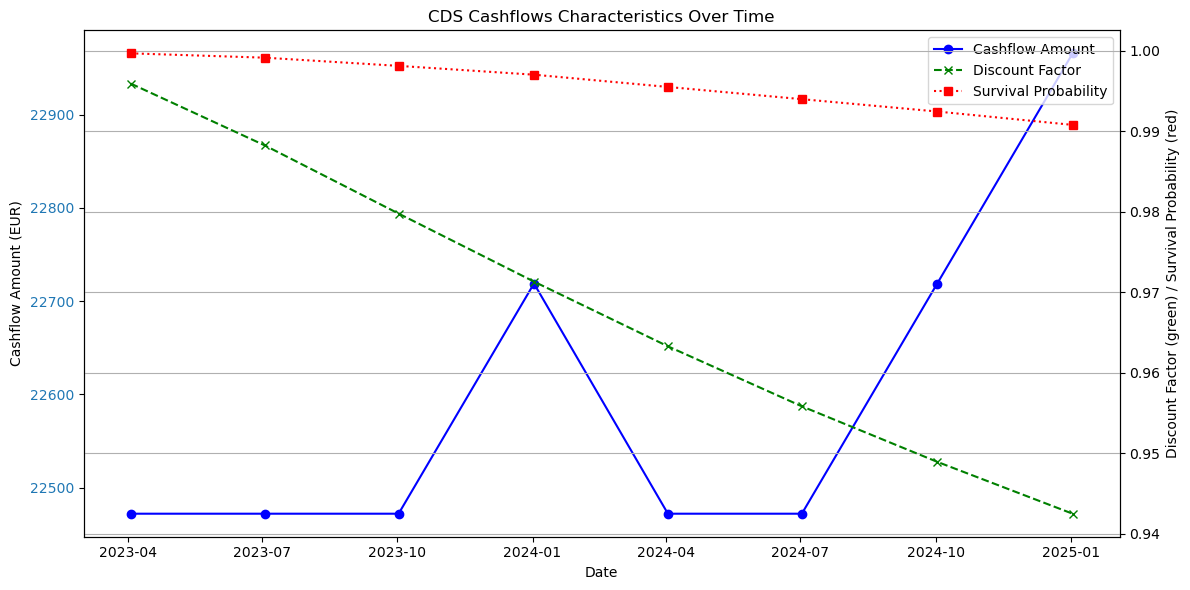

In [11]:
df = df_other_cashflows.copy()
df["cashFlowDatesArray"] = pd.to_datetime(df["cashFlowDatesArray"])

fig, ax1 = plt.subplots(figsize=(12, 6))
# Primary axis: Cashflow Amounts
ax1.plot(df["cashFlowDatesArray"], df["cashFlowTotalAmountsInDealCcyArray"],
         label="Cashflow Amount", color="blue", marker="o")
ax1.set(xlabel="Date", ylabel="Cashflow Amount (EUR)")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Secondary axis: Discount Factors & Survival Probabilities
ax2 = ax1.twinx()
ax2.plot(df["cashFlowDatesArray"], df["cashFlowDiscountFactorsArray"],
         label="Discount Factor", color="green", linestyle="--", marker="x")
ax2.plot(df["cashFlowDatesArray"], df["cashFlowSurvivalProbabilitiesArray"],
         label="Survival Probability", color="red", linestyle=":", marker="s")
ax2.set_ylabel("Discount Factor (green) / Survival Probability (red)", color="black")
ax2.tick_params(axis="y", labelcolor="black")

ax1.legend(ax1.get_lines() + ax2.get_lines(), [l.get_label() for l in ax1.get_lines() + ax2.get_lines()], loc="upper right")
plt.title("CDS Cashflows Characteristics Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
